In [1]:
!pip install xgboost
!pip install lightgbm
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.2 MB/s eta 0:00:00


In [28]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, make_scorer, brier_score_loss
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from joblib import dump, load
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, randint as sp_randint, uniform as sp_uniform
from scipy.cluster import hierarchy

In [29]:
seed = 42

In [30]:
# define Mcfadden's pseduo r-squared
def mcfadden_r2(y, y_pred):
    ll = log_loss(y, y_pred)
    ll_null = log_loss(y, np.full(len(y), y.mean()))
    return 1 - (ll/ll_null)
pseudo_r2_scorer = make_scorer(mcfadden_r2, needs_proba=True, greater_is_better=True)

In [31]:
scoring = {'roc_aug': 'roc_auc', 'mcfaddens_r2': pseudo_r2_scorer}

In [33]:
df = pd.read_csv("Statsbomb_Shots_WO_Outliers.csv")

/var/folders/b5/p9rmdc817y36m0hgtkqmx93m0000gn/T/ipykernel_21147/3945817868.py:1: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Statsbomb_Shots_WO_Outliers.csv")


In [34]:
df.drop(columns='Unnamed: 0',inplace=True)

In [35]:
df.head(10)

,match_id,id,eventSec,period,goal,team_id,team_name,player_id,shot_type_name,x,...,gk_player_id,firstName,middleName,lastName,Name,area_shot,area_goal,opps_in_n_angle,goalkeeper_x,goalkeeper_y
0,2275050,25e512a2-6ce0-41db-8749-88d988947058,780.422,2,False,969,Birmingham City WFC,15580.0,open_play,91.158333,...,33664.0,Claudia,NaN,Walker,Claudia Walker,3836.901495,757.206131,1.0,101.975000,29.606667
1,2275050,3ece6827-76fa-4ae1-8c4c-ef4af1ae4c4e,950.810,2,False,969,Birmingham City WFC,31563.0,free_kick,101.333333,...,33664.0,Rachel,NaN,Williams,Rachel Williams,5272.748045,200.239061,3.0,104.450000,36.470500
2,2275050,dcc3c9f6-1b25-4fb4-ae1a-5dcf52d16769,2386.037,1,False,969,Birmingham City WFC,15562.0,throw_in,84.471429,...,33664.0,Lucy,NaN,Staniforth,Lucy Staniforth,5509.133803,286.591404,2.0,102.066667,31.621000
3,2275050,9bdbfc3d-959d-4fc4-bac2-6b5d154191e9,746.245,1,False,974,Reading WFC,26570.0,free_kick,88.328571,...,22032.0,Amalie,Vevle,Eikeland,Amalie Vevle Eikeland,3791.877712,1048.194587,1.0,103.900000,31.529500
4,2275050,a2068f0f-d4fd-44e3-b1a2-2497d7b47b0a,902.629,1,False,974,Reading WFC,26570.0,free_kick,93.725000,...,22032.0,Amalie,Vevle,Eikeland,Amalie Vevle Eikeland,317.530346,1126.366907,1.0,104.175000,35.830000
5,2275050,8439b96b-fc49-4511-9628-059c2c996a83,2310.041,1,True,974,Reading WFC,26570.0,free_kick,85.671429,...,22032.0,Amalie,Vevle,Eikeland,Amalie Vevle Eikeland,3724.209813,1794.567066,0.0,99.408333,31.529500
6,2275050,db9cc459-2dbe-42b8-8c75-e50d1b49bdc5,1468.335,2,False,974,Reading WFC,26570.0,open_play,95.191667,...,22032.0,Amalie,Vevle,Eikeland,Amalie Vevle Eikeland,3969.499272,1197.269435,0.0,102.341667,37.843333
7,2275050,537f7379-0bf7-4bd4-be7f-7cc25c43de98,2626.523,2,False,974,Reading WFC,26570.0,open_play,94.733333,...,22032.0,Amalie,Vevle,Eikeland,Amalie Vevle Eikeland,6900.467557,613.895436,2.0,104.450000,32.444500
8,2275050,ce34292d-68c7-40e9-a949-31c5fc7f2ec7,781.452,1,False,974,Reading WFC,15723.0,open_play,84.471429,...,22032.0,Brooke,NaN,Chaplen,Brooke Chaplen,1896.902245,1086.456635,1.0,104.450000,36.653500
9,2275050,9c0ec486-fade-48fe-b57d-28a6a5e175ae,2748.546,1,False,974,Reading WFC,15723.0,open_play,93.541667,...,22032.0,Brooke,NaN,Chaplen,Brooke Chaplen,4442.202604,1003.381131,0.0,102.250000,31.255000


In [36]:
df['strong_foot'] = (((df.strong_foot.isin(['left', 'both'])) &(df.body_part_name == 'Left Foot')) |
                                    ((df.strong_foot.isin(['right', 'both'])) & (df.body_part_name == 'Right Foot')))

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32680 entries, 0 to 32679
Data columns (total 43 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   match_id                            32680 non-null  int64  
 1   id                                  32680 non-null  object 
 2   eventSec                            32680 non-null  float64
 3   period                              32680 non-null  int64  
 4   goal                                32680 non-null  bool   
 5   team_id                             32680 non-null  int64  
 6   team_name                           32680 non-null  object 
 7   player_id                           32680 non-null  float64
 8   shot_type_name                      32680 non-null  object 
 9   x                                   32680 non-null  float64
 10  y                                   32680 non-null  float64
 11  counter_attack                      32680

In [38]:
df.drop(['match_id', 'id', 'eventSec','period', 'player_id', 'competition_gender', 'team_name',
         'firstName', 'middleName', 'lastName', 'Name','team_id'], axis=1, inplace=True)
X = df.drop('goal', axis=1)
y = df.goal

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=seed, stratify=y)


In [40]:
print('Shots train', len(y_train), ';Number goals', y_train.sum(),
      ';Goals %: ', round(y_train.mean()*100, 1))
print('Shots test', len(y_test), ';Number goals', y_test.sum(),
      ';Goals %: ', round(y_test.mean()*100, 1))

Shots train 26144 ;Number goals 2921 ;Goals %:  11.2
Shots test 6536 ;Number goals 730 ;Goals %:  11.2


**LOGISTIC REGRESSION** 
                          

In [34]:
logisticReg_drop_cols = ['x', 'y',  # logistic regression does not deal well with dependent features
                      # The model will use the distance/ angle features capture these location features instead
                      # lots of missings for the below features as they come from StatsBomb data only.
                      # It's not fair to impute these as they are not missing at random
                      # while logistic regression does not allow missings so I removed them
                      'pass_end_y', 'pass_end_x','gk_player_id',
                      'goalkeeper_x', 'goalkeeper_y', 'carry_length', 'shot_one_on_one', 'shot_open_goal',
                      'under_pressure', 'area_shot', 'area_goal', 'opps_in_n_angle']
X_train_logistic = X_train.drop(logisticReg_drop_cols, axis=1).copy()
X_test_logistic = X_test.drop(logisticReg_drop_cols, axis=1).copy()

In [35]:
X_train_logistic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26144 entries, 8111 to 2939
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   shot_type_name                      26144 non-null  object 
 1   counter_attack                      26144 non-null  bool   
 2   fast_break                          26144 non-null  bool   
 3   strong_foot                         26144 non-null  bool   
 4   body_part_name                      26144 non-null  object 
 5   assist_type                         26144 non-null  object 
 6   pass_switch                         18493 non-null  object 
 7   pass_cross                          18493 non-null  object 
 8   pass_cut_back                       18493 non-null  object 
 9   pass_height_name                    18493 non-null  object 
 10  pass_technique_name                 18493 non-null  object 
 11  visible_angle                       261

In [36]:
def split(X, y):
    mask = X.assist_type == 'pass'
    X_pass = X[mask].drop('assist_type', axis=1).copy()
    y_pass = y[mask]
    X_other = X[~mask].dropna(axis=1, how='all').copy()
    y_other = y[~mask]
    return X_pass, y_pass, X_other, y_other

In [37]:
X_train_pass, y_train_pass, X_train_other, y_train_other = split(X_train_logistic, y_train)
X_test_pass, y_test_pass, X_test_other, y_test_other = split(X_test_logistic, y_test)

In [38]:
cols = ['shot_type_name', 'body_part_name', 'pass_technique_name', 'pass_height_name']
cats = [['open_play', 'free_kick', 'corner', 'throw_in'],
        ['Right Foot', 'Left Foot', 'Other'],
        ['other', 'Through Ball', 'Straight', 'Inswinging', 'Outswinging'],
        ['Ground/ Low Pass', 'High Pass']]
pass_one_hot = ColumnTransformer([('encoder', OneHotEncoder(drop='first', categories=cats), cols)], remainder='passthrough')
pipe_pass = Pipeline([('one_hot', pass_one_hot),
                      ('impute', SimpleImputer()),
                      ('scale', StandardScaler()),
                      ('lr', LogisticRegression(random_state=seed))])

In [39]:
original_cols_remain = [col for col in X_train_pass.columns if col not in cols]
new_cols_pass = [item for sublist in cats for i, item in enumerate(sublist) if (i>0)]
new_cols_pass.extend(original_cols_remain)

In [40]:
print(new_cols_pass)

['free_kick', 'corner', 'throw_in', 'Left Foot', 'Other', 'Through Ball', 'Straight', 'Inswinging', 'Outswinging', 'High Pass', 'counter_attack', 'fast_break', 'strong_foot', 'pass_switch', 'pass_cross', 'pass_cut_back', 'visible_angle', 'middle_angle', 'distance_to_goal', 'distance_visible_angle_interaction', 'log_distance']


In [41]:
# setting direct to recovery so does not not encoded twice ( also covered by shot_type_name == 'direct_set_piece')
X_train_other.loc[X_train_other.assist_type == 'direct', 'assist_type'] = 'recovery'
X_test_other.loc[X_test_other.assist_type == 'direct', 'assist_type'] = 'recovery'

cols = ['shot_type_name', 'body_part_name', 'assist_type']
cats = [['open_play', 'free_kick', 'corner', 'throw_in', 'direct_set_piece'],
        ['Right Foot', 'Left Foot', 'Other'],
        ['recovery', 'clearance', 'rebound']]
other_one_hot = ColumnTransformer([('encoder', OneHotEncoder(drop='first', categories=cats), cols)], remainder='passthrough')
pipe_other = Pipeline([('one_hot', other_one_hot),
                       ('impute', SimpleImputer()),
                       ('scale', StandardScaler()),
                       ('lr', LogisticRegression(random_state=seed))])

In [42]:
original_cols_remain = [col for col in X_train_other.columns if col not in cols]
new_cols_other = [item for sublist in cats for i, item in enumerate(sublist) if (i>0)]
new_cols_other.extend(original_cols_remain)

In [43]:
print(new_cols_other)

['free_kick', 'corner', 'throw_in', 'direct_set_piece', 'Left Foot', 'Other', 'clearance', 'rebound', 'counter_attack', 'fast_break', 'strong_foot', 'visible_angle', 'middle_angle', 'distance_to_goal', 'distance_visible_angle_interaction', 'log_distance']


In [44]:
param_grid = {'lr__C': np.logspace(-3, 0.1, 100)}

In [45]:
clf_pass = GridSearchCV(estimator=pipe_pass, param_grid=param_grid, scoring='neg_log_loss', n_jobs=-1)
clf_pass.fit(X_train_pass, y_train_pass)
print('C:', clf_pass.best_estimator_.named_steps.lr.C)

C: 0.049080512716538564


In [46]:
clf_other = GridSearchCV(estimator=pipe_other, param_grid=param_grid, scoring='neg_log_loss', n_jobs=-1)
clf_other.fit(X_train_other, y_train_other)
print('C:', clf_other.best_estimator_.named_steps.lr.C)

C: 0.1253082884091345


In [47]:
nested_score_pass = cross_validate(clf_pass, X=X_train_pass, y=y_train_pass, scoring=scoring, n_jobs=-1)
print('ROC AUC for shots assisted by passes:', nested_score_pass['test_roc_aug'].mean())
print("McFadden's Pseudo R-squared shots assisted by passes:", nested_score_pass['test_mcfaddens_r2'].mean())

ROC AUC for shots assisted by passes: 0.7768313893046214
McFadden's Pseudo R-squared shots assisted by passes: 0.1537325002723561


In [48]:
nested_score_other = cross_validate(clf_other, X=X_train_other, y=y_train_other, scoring=scoring, n_jobs=-1)
print('ROC AUC for other model:', nested_score_other['test_roc_aug'].mean())
print("McFadden's Pseudo R-squared for other model:", nested_score_other['test_mcfaddens_r2'].mean())

ROC AUC for other model: 0.7958303712093062
McFadden's Pseudo R-squared for other model: 0.1845338298052847


**LIGHT GBM**

In [44]:
!pip install imblearn
from imblearn.over_sampling import SMOTENC

In [84]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26144 entries, 8111 to 2939
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   shot_type_name                      26144 non-null  object 
 1   x                                   26144 non-null  float64
 2   y                                   26144 non-null  float64
 3   counter_attack                      26144 non-null  bool   
 4   fast_break                          26144 non-null  bool   
 5   strong_foot                         26144 non-null  bool   
 6   body_part_name                      26144 non-null  object 
 7   assist_type                         26144 non-null  object 
 8   pass_end_x                          18493 non-null  float64
 9   pass_end_y                          18493 non-null  float64
 10  pass_switch                         18493 non-null  object 
 11  pass_cross                          184

In [41]:
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 26144 entries, 8111 to 2939
Series name: goal
Non-Null Count  Dtype
--------------  -----
26144 non-null  bool 
dtypes: bool(1)
memory usage: 229.8 KB


In [42]:
columns_with_missing = ['pass_end_x', 'pass_end_y', 'pass_switch', 'pass_cross', 'pass_cut_back', 
                        'pass_height_name', 'pass_technique_name', 'shot_one_on_one', 'shot_open_goal', 
                        'opps_in_n_angle', 'goalkeeper_x', 'goalkeeper_y']

# create a SimpleImputer object, you can specify the strategy for imputing missing values
# here we use "most_frequent" strategy to replace missing values with the most frequent value in the column
imputer = SimpleImputer(strategy='most_frequent')

# fit the imputer to your DataFrame
imputer.fit(X_train[columns_with_missing])

# transform the DataFrame by replacing missing values with the imputed values
X_train[columns_with_missing] = imputer.transform(X_train[columns_with_missing])


In [45]:
smote_nc = SMOTENC(categorical_features=[0, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 19, 21, 24, 23], 
                   random_state=42, sampling_strategy='minority',k_neighbors=4)
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)


In [46]:
X_train_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46446 entries, 0 to 46445
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   shot_type_name                      46446 non-null  object 
 1   x                                   46446 non-null  float64
 2   y                                   46446 non-null  float64
 3   counter_attack                      46446 non-null  bool   
 4   fast_break                          46446 non-null  bool   
 5   strong_foot                         46446 non-null  bool   
 6   body_part_name                      46446 non-null  object 
 7   assist_type                         46446 non-null  object 
 8   pass_end_x                          46446 non-null  object 
 9   pass_end_y                          46446 non-null  object 
 10  pass_switch                         46446 non-null  object 
 11  pass_cross                          46446

In [47]:
def clean_lightgbm(df):
    df = df.copy()
    # replace categorical columns
    shot_type_cat = {'free_kick': 0, 'corner': 1, 'throw_in': 2, 'direct_set_piece': 3, 'open_play': 4}
    body_type_cat = {'Right Foot': 0, 'Left Foot': 1, 'Other': 2}
    assist_type_cat = {'pass': 0, 'recovery': 1, 'clearance': 2, 'direct': 3, 'rebound': 4}
    pass_height_cat = {'High Pass': 0, 'Ground/ Low Pass': 1}
    pass_technique_cat = {'Through Ball': 0, 'Straight': 1, 'Inswinging': 2, 'Outswinging': 3, 'other': 4}
    df.shot_type_name.replace(shot_type_cat, inplace=True)
    df.body_part_name.replace(body_type_cat, inplace=True)
    df.assist_type.replace(assist_type_cat, inplace=True)
    df.pass_height_name.replace(pass_height_cat, inplace=True)
    df.pass_technique_name.replace(pass_technique_cat, inplace=True)

    # replace boolean type columns (not really as have nans)
    for col in ['pass_switch', 'pass_cross', 'pass_cut_back', 'shot_one_on_one',
                'shot_open_goal', 'under_pressure', 'pass_end_x' , 'pass_end_y', 'opps_in_n_angle', 'goalkeeper_x', 'goalkeeper_y']:
        df[col] = df[col].astype(np.float32)
    # drop some distance/ angle columns
    drop_cols = ['visible_angle', 'middle_angle', 'distance_to_goal', 'distance_visible_angle_interaction',
                 'log_distance', 'gk_player_id']
    df.drop(drop_cols, axis=1, inplace=True)
    return df
    
X_test = clean_lightgbm(X_test)

# lightGBM -SMOTENC

In [89]:
#model_id = 1
#X_train_resampled = clean_lightgbm(X_train_resampled)
lgbmSMOTE = CalibratedClassifierCV(LGBMClassifier(random_state=42), method='isotonic', cv=3, ensemble=True, n_jobs=-1)
lgbm_param_grid = {'base_estimator__min_child_samples': sp_randint(0, 400),
                   'base_estimator__num_leaves': sp_randint(2, 600),
                   'base_estimator__reg_lambda': sp_uniform(0, 1),
                   'base_estimator__reg_alpha': sp_uniform(0, 1),
                   'base_estimator__max_depth': sp_randint(0, 700)}
searchcvSMOTE = RandomizedSearchCV(estimator=lgbmSMOTE,
                              n_iter=200,
                              param_distributions=lgbm_param_grid,
                              cv=5,
                              n_jobs=-1)
searchcvSMOTE.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(cv=5,
                   estimator=CalibratedClassifierCV(base_estimator=LGBMClassifier(random_state=42),
                                                    cv=3, method='isotonic',
                                                    n_jobs=-1),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'base_estimator__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f8974288250>,
                                        'base_estimator__min_child_samples': <scipy.stats._distn_infrastru...ozen object at 0x7f89733ec0a0>,
                                        'base_estimator__num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f89735afb20>,
                                        'base_estimator__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f89735af610>,
                                        'base_estimator__reg_lambda': <scipy.stats._distn_infrastr

In [90]:
perm_result = permutation_importance(searchcvSMOTE.best_estimator_, X_train_resampled, y_train_resampled, n_repeats=10, random_state=seed)
df_perm_importance1 = pd.DataFrame({'Feature':X_train_resampled.columns,
                                   'importance': perm_result.importances.mean(axis=1),
                                   'std_dev': perm_result.importances.std(axis=1)})
df_perm_importance1.sort_values('importance', ascending=False, inplace=True)
df_perm_importance1.reset_index(drop=True, inplace=True)

In [91]:
df_perm_importance1

,Feature,importance,std_dev
0,carry_length,0.197350,0.001356
1,x,0.186927,0.001195
2,y,0.091930,0.000941
3,opps_in_n_angle,0.083021,0.000808
4,goalkeeper_x,0.035536,0.000747
5,area_goal,0.024297,0.000273
6,pass_end_x,0.022969,0.000370
7,area_shot,0.020986,0.000408
8,shot_open_goal,0.018751,0.000538
9,goalkeeper_y,0.014587,0.000471


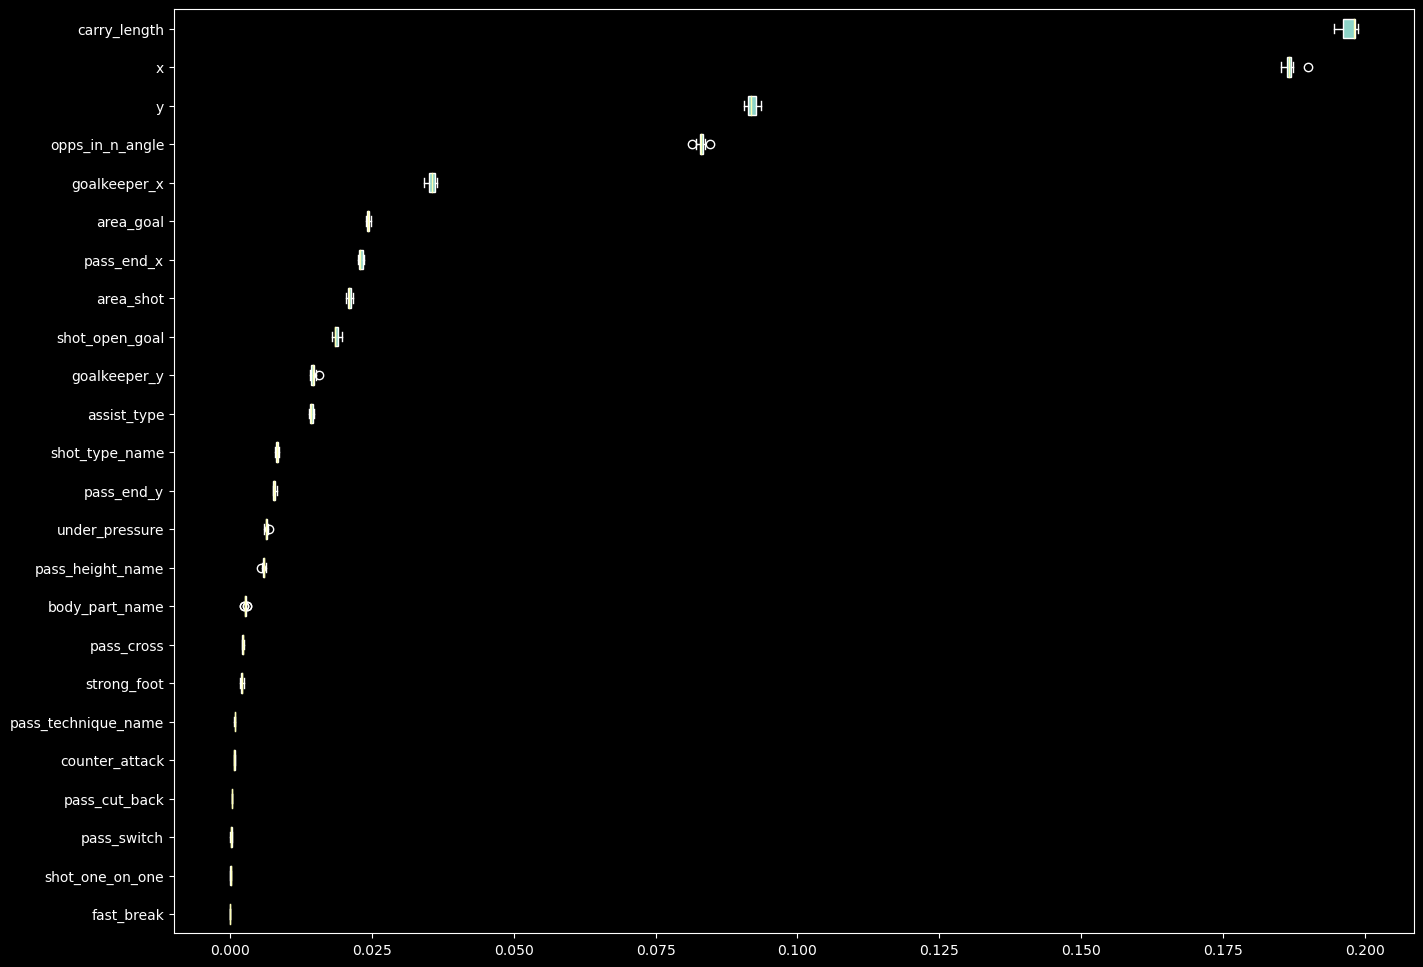

In [92]:
fig, ax = plt.subplots(figsize=(16, 12))
sorted_idx = perm_result.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result.importances[sorted_idx].T, vert=False, labels=X_train_resampled.columns[sorted_idx],patch_artist=True)

# lightGBM

In [84]:
# model_id = 2
lgbm = CalibratedClassifierCV(LGBMClassifier(random_state=42), method='isotonic', ensemble=True ,cv=3, n_jobs=-1)
lgbm_param_grid = {'base_estimator__min_child_samples': sp_randint(0, 400),
                   'base_estimator__num_leaves': sp_randint(2, 600),
                   'base_estimator__reg_lambda': sp_uniform(0, 1),
                   'base_estimator__reg_alpha': sp_uniform(0, 1),
                   'base_estimator__max_depth': sp_randint(0, 700)}
searchcv = RandomizedSearchCV(estimator=lgbm,
                              n_iter=100,
                              param_distributions=lgbm_param_grid,
                              cv=5,
                              n_jobs=-1)
searchcv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=CalibratedClassifierCV(base_estimator=LGBMClassifier(random_state=42),
                                                    cv=3, method='isotonic',
                                                    n_jobs=-1),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'base_estimator__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f89733ec970>,
                                        'base_estimator__min_child_samples': <scipy.stats._distn_infrastru...ozen object at 0x7f89733ecb80>,
                                        'base_estimator__num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f8973127640>,
                                        'base_estimator__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f8972e321f0>,
                                        'base_estimator__reg_lambda': <scipy.stats._distn_infrastr

In [85]:
perm_result = permutation_importance(searchcv.best_estimator_, X_train, y_train, n_repeats=10, random_state=seed)
df_perm_importance2 = pd.DataFrame({'Feature':X_train.columns,
                                   'importance': perm_result.importances.mean(axis=1),
                                   'std_dev': perm_result.importances.std(axis=1)})
df_perm_importance2.sort_values('importance', ascending=False, inplace=True)
df_perm_importance2.reset_index(drop=True, inplace=True)

In [86]:
df_perm_importance2

,Feature,importance,std_dev
0,x,0.061750,0.000934
1,carry_length,0.058472,0.001110
2,y,0.046971,0.000626
3,goalkeeper_x,0.025597,0.000628
4,area_shot,0.012167,0.000340
5,area_goal,0.011743,0.000390
6,goalkeeper_y,0.010362,0.000419
7,pass_end_y,0.009670,0.000288
8,pass_end_x,0.008434,0.000374
9,pass_height_name,0.005607,0.000607


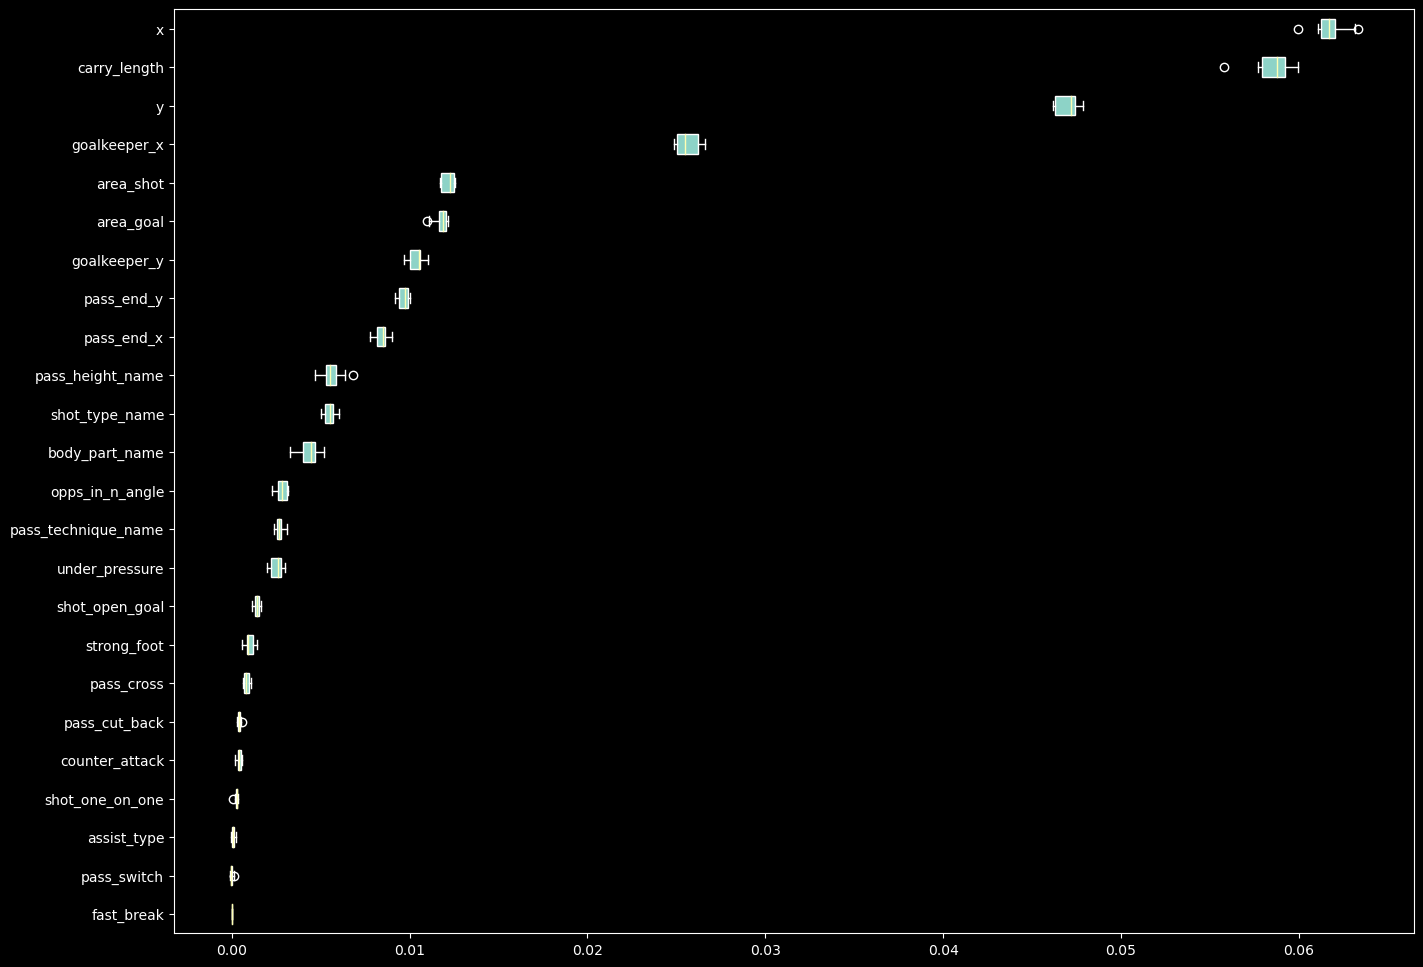

In [87]:
fig, ax = plt.subplots(figsize=(16, 12))
sorted_idx = perm_result.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx],patch_artist=True)

<b>Results</b>

In [93]:
#Light GBM - SMOTE NC
y_pred_lgbmSMOTE_calibrated = searchcvSMOTE.best_estimator_.predict_proba(X_test)[:, 1]
fraction_of_positives_lgbmSMOTE, mean_predicted_value_lgbmSMOTE = calibration_curve(y_test, y_pred_lgbmSMOTE_calibrated, n_bins=10)

# Light GBM 
y_pred_lgbm_calibrated = searchcv.best_estimator_.predict_proba(X_test)[:, 1]
fraction_of_positives_lgbm, mean_predicted_value_lgbm = calibration_curve(y_test, y_pred_lgbm_calibrated, n_bins=10)

# logistic regression
y_pred_lr_pass = clf_pass.predict_proba(X_test_pass)[:, 1]
y_pred_lr_other = clf_other.predict_proba(X_test_other)[:, 1]
y_pred_lr = np.concatenate([y_pred_lr_pass, y_pred_lr_other])
y_true_test = np.concatenate([y_test_pass, y_test_other])
fraction_of_positives_lr, mean_predicted_value_lr = calibration_curve(y_true_test, y_pred_lr, n_bins=10)

In [94]:
print('Brier score, Light GBM - SMOTENC:', brier_score_loss(y_test, y_pred_lgbmSMOTE_calibrated, pos_label=y_test.max()))
print('ROC AUC, Light GBM - SMOTENC:', roc_auc_score(y_test, y_pred_lgbmSMOTE_calibrated))
print('Pseudo R-squared, Light GBM - SMOTENC:', mcfadden_r2(y_test, y_pred_lgbmSMOTE_calibrated))

Brier score, Light GBM - SMOTENC: 0.07897913178965948
ROC AUC, Light GBM - SMOTENC: 0.85561240379579
Pseudo R-squared, Light GBM - SMOTENC: 0.2183006236681626


In [95]:
print('Brier score, Logistic Regression:', brier_score_loss(y_true_test, y_pred_lr, pos_label=y_test.max()))
print('ROC AUC, Logistic Regression:', roc_auc_score(y_true_test, y_pred_lr))
print('Pseudo R-squared, Logistic Regression:', mcfadden_r2(y_true_test, y_pred_lr))

Brier score, Logistic Regression: 0.08687269716488388
ROC AUC, Logistic Regression: 0.7755756916557741
Pseudo R-squared, Logistic Regression: 0.14939910887195196


In [96]:
print('Brier score, Light GBM:', brier_score_loss(y_test, y_pred_lgbm_calibrated, pos_label=y_test.max()))
print('ROC AUC, Light GBM:', roc_auc_score(y_test, y_pred_lgbm_calibrated))
print('Pseudo R-squared, Light GBM:', mcfadden_r2(y_test, y_pred_lgbm_calibrated))

Brier score, Light GBM: 0.06849795514205859
ROC AUC, Light GBM: 0.8917297410803185
Pseudo R-squared, Light GBM: 0.34630592628950774


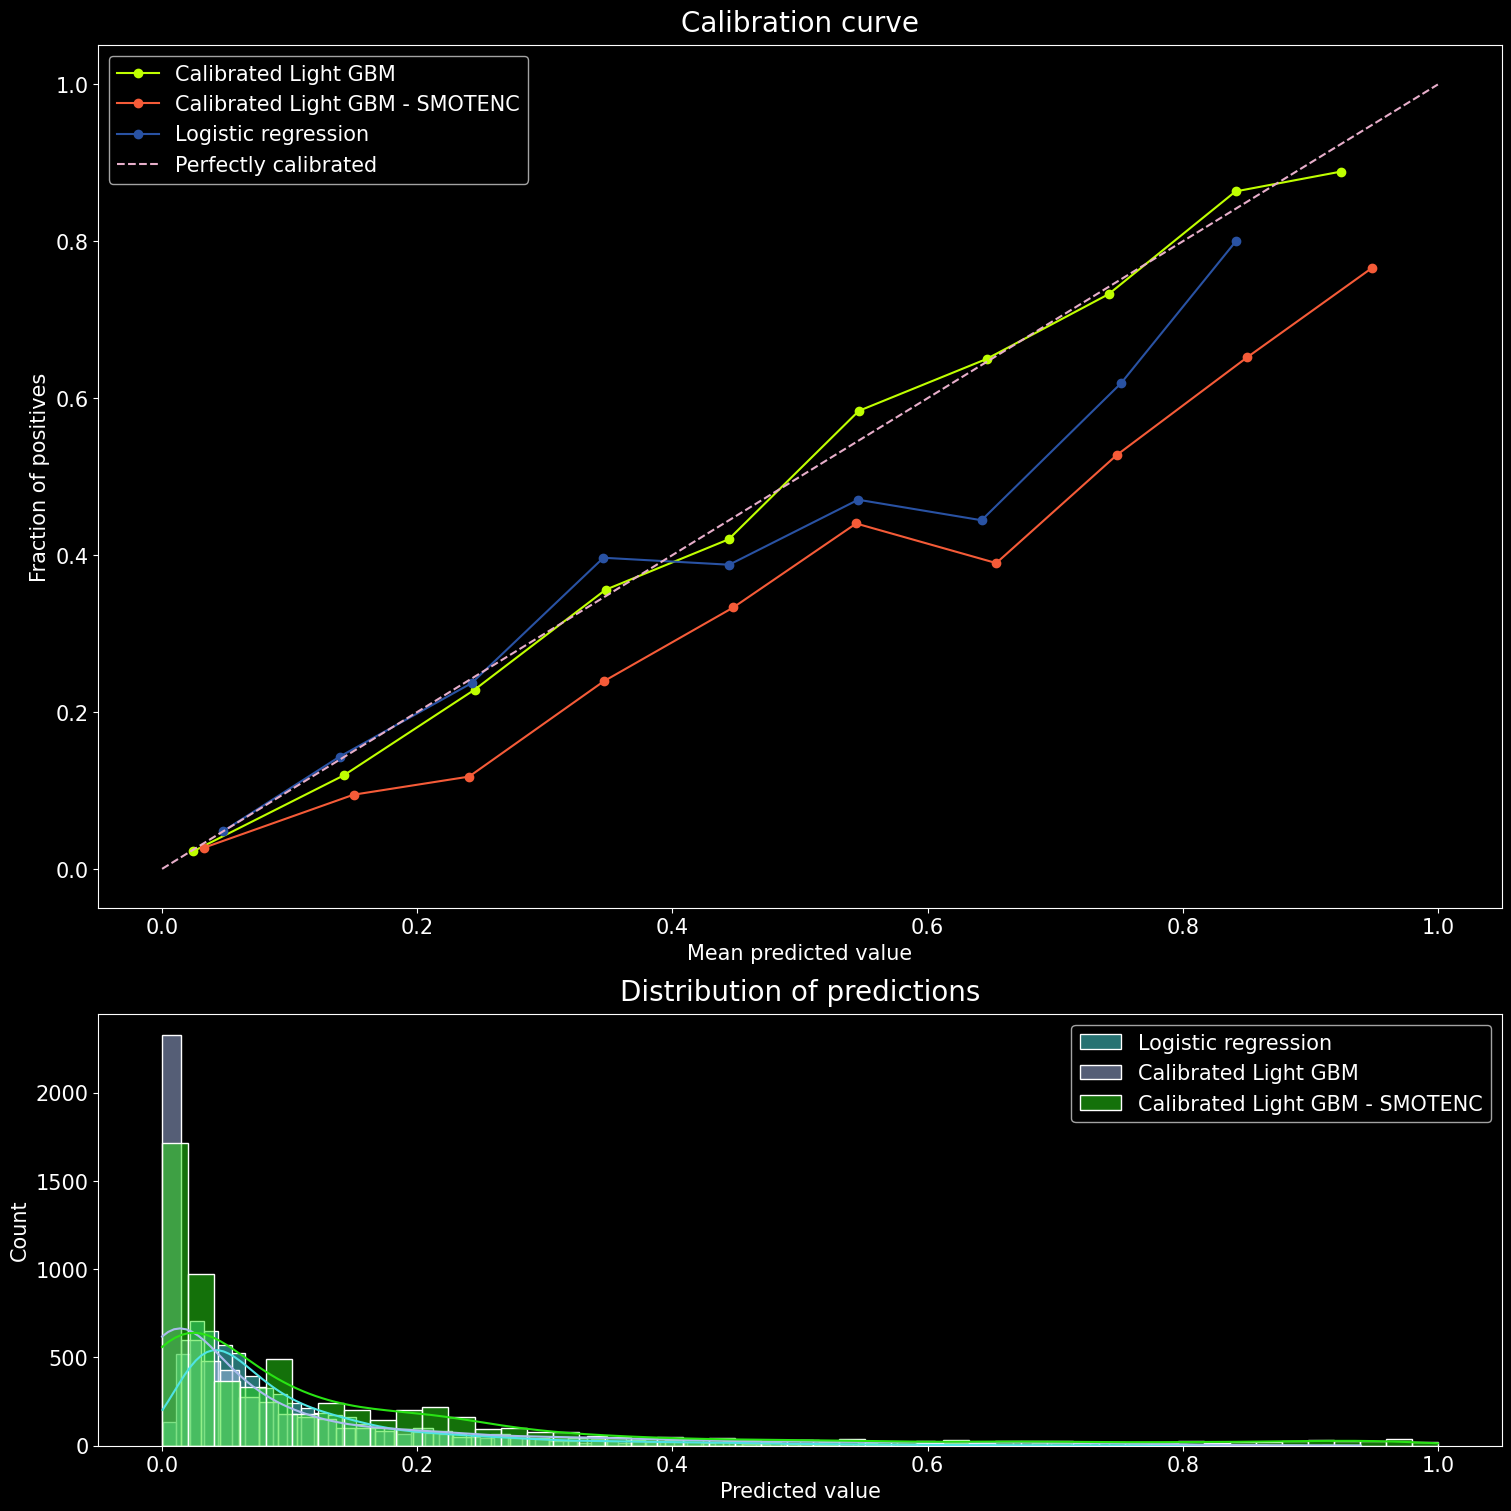

In [97]:
plt.style.use('dark_background')
fig = plt.figure(constrained_layout=True, figsize=(15, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_lgbm, fraction_of_positives_lgbm, "-o", color='#bfff00', label='Calibrated Light GBM')
ax1.plot(mean_predicted_value_lgbmSMOTE, fraction_of_positives_lgbmSMOTE, "-o", color='#f55b38', label='Calibrated Light GBM - SMOTENC')
ax1.plot(mean_predicted_value_lr, fraction_of_positives_lr, "-o", color='#2952a3', label='Logistic regression')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.histplot(y_pred_lr, color='#4fe4e4', label='Logistic regression', kde=True, ax=ax2)
sns.histplot(y_pred_lgbm_calibrated, color='#aabced', label='Calibrated Light GBM', kde=True, ax=ax2)
sns.histplot(y_pred_lgbmSMOTE_calibrated, color='#29e314', label='Calibrated Light GBM - SMOTENC', kde=True, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10);